In [1]:
using StatsBase
using Statistics
using CSV
using Plots
using StatsPlots
using TikzPictures
using DSP
using Measurements
using CRC
using Optim

#pgfplots()
#tikzCommand("lualatex") # The default. Dynamically allocates more memory, unlike PDFLaTeX
gr()

Plots.GRBackend()

Set publication-quality settings for plots.

In [2]:
upscale = 1 #8x upscaling in resolution
fntsm = Plots.font("sans-serif", pointsize=round(10.0*upscale))
fntlg = Plots.font("sans-serif", pointsize=round(14.0*upscale))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntsm, legendfont=fntsm)
default(size=(800*upscale,600*upscale)) #Plot canvas size
#default(dpi=300) #Only for PyPlot - presently broken?

# Delayed Signal Computations

## DAC Rise Time

In [3]:
rtdata = CSV.File("./data/Tek004.csv"; header=false)
rtweights = FrequencyWeights(rtdata.Column2)
rt = mean(rtdata.Column1, rtweights)
rtσ = std(rtdata.Column1, rtweights, corrected=true)

1.1492676743389036e-9

In [4]:
rtσ /= 4 # For a 1 Vpp square wave edge
rt /= 4

1.290866506382043e-7

## Delay Error

The steps in the error plots are in single-digit intervals, so the results should taken with a grain of salt

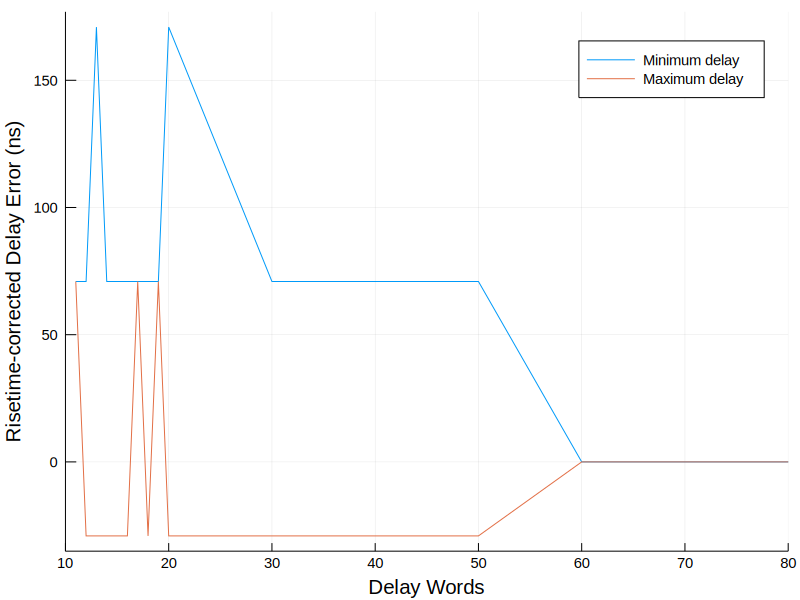

In [5]:
dlimit=35;
ddata = CSV.File("./delay_linearity.csv"; skipto=2, limit=dlimit, header=[:min, :max, :swords, :na, :clock, :signal, :rt]);
rtcorrection = vcat(repeat([rt], 13), zeros(dlimit-13));
minerr = 1e-3.*ddata.min .- (ddata.swords .* 20e-6) .+ 20e-6 - rtcorrection;
maxerr = 1e-3.*ddata.max .- (ddata.swords .* 20e-6) - rtcorrection;
plot(ddata.swords, [minerr, maxerr] ./ 1e-9,
    xlim=(10,80), xlabel="Delay Words", ylabel="Risetime-corrected Delay Error (ns)",
    label=["Minimum delay", "Maximum delay"])

## Estimated Internal Propagation Delay

Roughly estimated from risetime-corrected delay data.

In [6]:
pt = mean(map(mean, [minerr[1:13], maxerr[1:13]])) ./ 1e-9 # ns

40.14411859255405

## In-Out Difference Mean

In [7]:
meandata = CSV.File("./data/diffmean2.csv"; header=false);
meanweights = FrequencyWeights(meandata.Column2);
diffμ = mean(meandata.Column1, meanweights);
diffμσ = std(meandata.Column1, meanweights, corrected=true);
(diffμ ± diffμσ) * 1e3 # mV

-1.023 ± 0.095

## In-Out Difference ACRMS (Standard Deviation)

In [8]:
acrmsdata = CSV.File("./data/diffacrms2.csv"; header=false);
acrmsweights = FrequencyWeights(acrmsdata.Column2);
diffσ = mean(acrmsdata.Column1, acrmsweights);
diffσσ = std(acrmsdata.Column1, acrmsweights, corrected=true);
(diffσ ± diffσσ) * 1e3 # mV (RMS)

1.035 ± 0.058

# Output Plots

- Input: 50 Hz sine wave.
- Clock: 50 kHz.
- Delay: 1000 swords.
- Measurement Bandwidth: 100 MHz.

In [9]:
diff500 = CSV.File("./data/500HzDiff100MHz.csv", skipto=10, header=[:t, :v]) # Oops: is actually 50 Hz

CSV.File("./data/500HzDiff100MHz.csv"):
Size: 1250000 x 2
Tables.Schema:
 :t  Float64
 :v  Float64

In [10]:
# Resample/decimate for faster plotting
#ddiff500t = resample(diff500.t, 1 // 10);
#ddiff500v = resample(diff500.v, 1 // 10);

ddiff500t = diff500.t;
ddiff500v = diff500.v;

- Input: 5 kHz sine wave.
- Clock: 5 MHz.
- Delay: 1000 swords.
- Measurement Bandwidth: 250 MHz.

In [11]:
diff5M = CSV.File("./data/5MHzDiff250MHz.csv", skipto=10, header=[:t, :v]) # Oops: signal is 5 kHz

CSV.File("./data/5MHzDiff250MHz.csv"):
Size: 625000 x 2
Tables.Schema:
 :t  Float64
 :v  Float64

In [12]:
# Resample/decimate for faster plotting
#ddiff5Mt = resample(diff5M.t, 1 // 10);
#ddiff5Mv = resample(diff5M.v, 1 // 10);

ddiff5Mt = diff5M.t;
ddiff5Mv = diff5M.v;

Generate all of the plots.

In [13]:
p500 = plot(ddiff500t .* 50.0 * 360, ddiff500v .* 1e3, ylabel="Vin - Vout (mV)",
    xticks=-180:45:180, ylim=(-25, 25), legend=false, color=:black, linewidth=0.25);

In [14]:
p500d = plot(ddiff500t .* 50.0 * 360, ddiff500v .* 1e3,
    xticks=-5:1:5, xlim=(-3, 3), ylim=(-80, 20), legend=false, color=:black, linewidth=0.25);

In [15]:
p5M = plot(ddiff5Mt .* 5e3 * 360, ddiff5Mv .* 1e3, xlabel="Phase (deg)", ylabel="Vin - Vout (mV)",
    xticks=-180:45:180, ylim=(-25, 25), legend=false, color=:lightgray, linewidth=0.25);

In [16]:
p5Md = plot(ddiff5Mt .* 5e3 * 360, ddiff5Mv .* 1e3, xlabel="Phase (deg)",
    xticks=-5:1:5, xlim=(-3, 3), ylim=(-80, 20), legend=false, color=:black, linewidth=0.25);

In [17]:
pdiffs = plot(p500, p500d, p5M, p5Md, layout = @layout [a b; c d]);

Save the single combined plot. This is significantly faster than if all of the plots above were individually shown and then combined.

In [18]:
savefig(pdiffs, "pdiffs.png")

# Varying Output Filters

Sallen-key topology (implementation).

In [19]:
# Bessel
#Q = √(3.) / 3.;
#ω0 = √(3.);
Q = 1. / 2; # C1 = C2, simple
ω0 = 1.;
sallen_key = convert(ZeroPoleGain, Biquad(0., 0., ω0^2, ω0 / Q, ω0^2));

Bessel filter.

In [20]:
# Reverse Bessel polynomial θₙ(s)
θ(n, s) = sum(k -> (factorial(2n - k) / (2^(n-k) * factorial(k) * factorial(n - k))) * s^k, 0:n)
Bessel2 = convert(ZeroPoleGain, Biquad(0.0, 0.0, θ(2, 0.0), 3.0, 3.0));

Butterworth filter.

In [21]:
Butterworth2 = Butterworth(2);

Plot all filters on the original signal to see how they perform.

In [22]:
f0 = 100e3;
responsetype = [Lowpass(f; fs = 1. / 3.2e-10) for f in [f0]];
designmethod = [(Butterworth2, "Butterworth (2nd-order)"), (sallen_key, "Sallen Key (w0 = $ω0, Q = $Q)"), (Bessel2, "Bessel (second-order)")];
filters = [(digitalfilter(r, d[1]), d[2]) for r in responsetype for d in designmethod];
fp5M = plot(p5M, legend=true, label="Unfiltered", title="$(f0/1e3) kHz filters on 5 MHz clock difference data");  
map(f -> plot!(ddiff5Mt .* 5e3 * 360, filt(f[1], ddiff5Mv) .* 1e3, xlabel="Phase (deg)", ylabel="Vin - Vout (mV)",
                xticks=-180:45:180, xlim=(-50, 50), ylim=(-15, 15), label=f[2], linewidth=0.25),
    filters);
savefig(fp5M, "fp5M.pdf")

# Initial History Programming

In [23]:
little_endian(x) = UInt8.([x & 0x00FF, x >> 8]);

In [24]:
#prog_words = rand(UInt16, 4096) .& 0x0FFF;
prog_words = [0x0000, 0x07FF, 0x0FFF, 0x07FF, 0x0000, 0x07FF, 0x0FFF, 0x07FF, 0x0000, 0x07FF, 0x0FFF, 0x07FF, 0x0000, 0x07FF, 0x0FFF, 0x07FF];
#prog_words = ones(UInt16, 16) .* 0x0FFF;
waveform_file = "./serial_data.bin";
write(waveform_file, prog_words);
#println(@. 2.5 * (-1. + 2. * Float64(prog_words) / Float64(0x0FFF)));
crc32 = crc(CRC_32);
prog_crc = crc32(vcat(little_endian.(prog_words)...));
display(prog_crc);

0x7a569719

In [25]:
prog_words

16-element Array{UInt16,1}:
 0x0000
 0x07ff
 0x0fff
 0x07ff
 0x0000
 0x07ff
 0x0fff
 0x07ff
 0x0000
 0x07ff
 0x0fff
 0x07ff
 0x0000
 0x07ff
 0x0fff
 0x07ff

## Initial History Programming Instructions

- Open *Realterm*.
- On the *Display* tab, check the *newLine mode* box.
- On the *Port* tab, set the *Baud* rate to *115200*.
- Select the *Port* that the *Arduino Due* is plugged in to, such as `6 = \USBSER000`.
- Press enter in the *Port* field to open the port. You should see text from the Arduino Due.
- On the *Send* tab, select the first text field.
- Type `ph N`, where `N` is the number of words that you want to program.
- Click the *Send ASCII* button. (Do not include a line feed in this command, as it will be interpreted as data).
- In the *Dump File to Port* section, click the ellipses (`...`) box.
- Select the history data file that you want to program.
- Under *Delays*, set the first entry (*Character Delay*) to `1`.
- Click *Send File*. You should see a hexdump of the data from the Arduino Due as it is transmitted.
- At the end of the transmission, there will be a line that says `CRC: 0x...`. Check that this matches the `CRC_32` of the sent data (little-endian).
- Send the `go` command to the Arduino Due to switch to the external input and clocks.

In [26]:
1/(2π*0.1e3*15e-9)

106103.29539459689

# Filtered Output Plots

## Signal A

- Input: 5 kHz sine wave.
- Clock: 5 MHz.
- Delay: 1000 swords.
- Measurement Bandwidth: 250 MHz.

In [27]:
ain = CSV.File("./data/5-5-in.csv", skipto=10, header=[:t, :v]); # Input signal
aout = CSV.File("./data/5-5-unfiltered.csv", skipto=10, header=[:t, :v]); # Unfiltered output
arc = CSV.File("./data/5-5-106kHz-RC.csv", skipto=10, header=[:t, :v]); # 106 kHz RC filter (single-pole)
abessel4 = CSV.File("./data/5-5-bessel4.csv", skipto=10, header=[:t, :v]); # ~121 kHz Bessel filter (four-pole)

In [28]:
abessel4vpp = maximum(abessel4.v) - minimum(abessel4.v);

In [29]:
pain = plot(ain.t .* 1e6, ain.v .* 1e3, label="Input");

In [30]:
paout = plot!(aout.t .* 1e6, aout.v .* 1e3, label="Unfiltered Output");

In [31]:
parc = plot!(arc.t .* 1e6, arc.v .* 1e3, label="106 kHz 1p LPF");

In [80]:
pabessel4 = plot!(abessel4.t .* 1e6, abessel4.v * 1e3 * (1.0 / abessel4vpp), label="~121 kHz 4p Bessel LPF (rescaled)",
    xlabel="Time (us)", ylabel="Output Voltage (mV)", xlim=(0, 200), ylim=(-750, 750), legend=:topright, linewidth=0.25);

In [33]:
savefig(pabessel4, "pa.pdf")

## Signal B

- Input: 20 kHz symmetric triangle wave.
- Clock: 5 MHz.
- Delay: 1000 swords.
- Measurement Bandwidth: 250 MHz.

In [34]:
bin = CSV.File("./data/5-20-in.csv", skipto=10, header=[:t, :v]); # Input signal. ZI: 6249.5
bout = CSV.File("./data/5-20-unfiltered.csv", skipto=10, header=[:t, :v]); # Unfiltered output
brc = CSV.File("./data/5-20-RC.csv", skipto=10, header=[:t, :v]); # 106 kHz RC filter (single-pole)
bbessel4 = CSV.File("./data/5-20-bessel4.csv", skipto=10, header=[:t, :v]); # ~121 kHz Bessel filter (four-pole). ZI: -0.5

In [35]:
bbessel4vpp = maximum(bbessel4.v) - minimum(bbessel4.v);

In [36]:
pbout = plot(bout.t .* 1e6, bout.v .* 1e3, label="Unfiltered");

In [37]:
pbrc = plot!(brc.t .* 1e6, brc.v .* 1e3, label="106 kHz 1p LPF");

In [38]:
pbbessel4 = plot!(bbessel4.t .* 1e6, bbessel4.v * 1e3 * (1.0 / bbessel4vpp), label="~121 kHz 4p Bessel LPF (rescaled)",
    xlabel="Time (us)", ylabel="Output Voltage (mV)", xlim=(0, 50), ylim=(-750, 750), legend=:topright, linewidth=0.25);

In [39]:
savefig(pbbessel4, "pb.pdf")

## Nelder-Mead Optimization of Filter Output Gain and Phase

In [81]:
sΔt = 3.2e-10;
span = 0.5;
margin = (1 - span) / 2;
function slidesamples(x, n, m)
    xlen = length(x);
    a = mod(Int64(floor(n)), xlen);
    b = mod(Int64(floor(n) + floor(m)), xlen);
    x[a:b]
end
stdslide(x; m=margin) = slidesamples(x, m*length(x), span*length(x));
function modifywave(y, n, k, off)
    off .+ (k .* slidesamples(y, n * length(y), span*length(y)))
end
function waveerr(x, y, s)
    xlen = length(x);
    rms(stdslide(x) .- modifywave(y, s...))
end

waveerr (generic function with 1 method)

In [41]:
arcoptim = optimize(s -> waveerr(ain.v, arc.v, s), [margin, 1., 0.])

 * Status: success

 * Candidate solution
    Minimizer: [2.43e-01, 1.01e+00, 2.20e-03]
    Minimum:   4.372209e-03

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [2.50e-01, 1.00e+00, 0.00e+00]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Iterations:    85
    f(x) calls:    177


In [42]:
abessel4optim = optimize(s -> waveerr(ain.v, abessel4.v, s), [margin, 1.0 / abessel4vpp, 0.])

 * Status: success

 * Candidate solution
    Minimizer: [2.50e-01, 2.54e-01, 1.61e-02]
    Minimum:   2.959149e-03

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [2.50e-01, 2.54e-01, 0.00e+00]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Iterations:    84
    f(x) calls:    182


In [43]:
arco = modifywave(arc.v, arcoptim.minimizer...);

In [44]:
abessel4o = modifywave(abessel4.v, abessel4optim.minimizer...);

In [74]:
plot(stdslide(aout.t) .* 1e6, stdslide(aout.v) .* 1e3, label="Unfiltered Output");
plot!(stdslide(abessel4.t) .* 1e6, stdslide(abessel4.v) .* 1e3 * abessel4optim.minimizer[2], label="~121 kHz 4p Bessel LPF (rescaled)");
paout = plot!(stdslide(arc.t) .* 1e6, stdslide(arc.v) .* 1e3, label="106 kHz 1p (RC) LPF", legend=:topleft);

In [75]:
savefig(paout, "paout.png")

In [63]:
parc = plot(stdslide(arc.t) .* 1e6, arco .* 1e3, label="Optimized RC LPF");
pabessel4 = plot!(stdslide(abessel4.t) .* 1e6, abessel4o .* 1e3, label="Optimized Bessel LPF",
    xlabel="Time (us)", ylabel="Output Voltage (mV)", legend=:topleft, linewidth=0.25);
pain = plot!((stdslide(ain.t) .+ 6250*sΔt .+ (abessel4.t[1] - ain.t[1])/2) .* 1e6, stdslide(ain.v) .* 1e3, label="Input");

In [64]:
savefig(pain, "pain.png")

In [51]:
arcodiff = stdslide(ain.v) .- arco;
abessel4odiff = stdslide(ain.v) .- abessel4o;

In [76]:
difff0 = 20e6;
difffilter = digitalfilter(Lowpass(difff0; fs = 1. / 3.2e-10), Bessel2);

In [77]:
plot(stdslide(arc.t) .* 1e6, arcodiff .* 1e3, label="RC Difference", xlim=(100,300));
plot!(stdslide(abessel4.t) .* 1e6, abessel4odiff .* 1e3, label="Bessel Difference", xlim=(100,300));

In [78]:
plot!(stdslide(arc.t) .* 1e6, filt(difffilter, arcodiff) .* 1e3,
    linewidth=1.5, label="RC at $(difff0 / 1e6) MHz BW", xlim=(100,300));
padiff = plot!(stdslide(abessel4.t) .* 1e6, filt(difffilter, abessel4odiff) .* 1e3,
    linewidth=1.5, label="Bessel at $(difff0 / 1e6) MHz BW", xlim=(100,300));

In [79]:
savefig(padiff, "padiff.png")